#Final Project on Advanced Topics in Deep Learning

##Preparing data

### Downloading the dataset and unzip

In [ ]:
# Install gdown if not already installed
!pip install gdown

# Download dataset from Google Drive
!gdown --id 1Ay0iVLhwyfGmHSR_8NYApURBvmWHtZEN -O archived.zip

# Extract the ZIP file
!unzip -q archived.zip -d dataset


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Ay0iVLhwyfGmHSR_8NYApURBvmWHtZEN
From (redirected): https://drive.google.com/uc?id=1Ay0iVLhwyfGmHSR_8NYApURBvmWHtZEN&confirm=t&uuid=da21f3ae-2844-4be1-9283-48db6de4dc08
To: /content/archived.zip
100% 256M/256M [00:05<00:00, 50.8MB/s]


###Convert the images to a grayscale

In [ ]:
import os
import cv2
from tqdm import tqdm

input_folder = "dataset/withBackground"  # Color images folder
output_folder = "dataset/grayscale"  # Grayscale images folder

os.makedirs(output_folder, exist_ok=True)

for root, _, files in os.walk(input_folder):
    for filename in tqdm(files):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, filename)
            rel_path = os.path.relpath(root, input_folder)
            save_folder = os.path.join(output_folder, rel_path)

            os.makedirs(save_folder, exist_ok=True)

            gray_path = os.path.join(save_folder, filename)

            img = cv2.imread(img_path)
            if img is None:
                continue

            # Convert to grayscale and save
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(gray_path, gray_img)


0it [00:00, ?it/s]
100%|██████████| 131/131 [00:01<00:00, 118.85it/s]


###Match between color image and grayscale image and normalize the data

In [ ]:
import numpy as np
import cv2
import os
from tqdm import tqdm

def load_images(folder, color_mode):
    images = []
    for root, _, files in os.walk(folder):
        for filename in tqdm(files):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, filename)

                img = cv2.imread(img_path, cv2.IMREAD_COLOR if color_mode else cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (128, 128))  # Resize images to 128x128
                img = img / 255.0  # Normalize pixel values

                if not color_mode:
                    img = np.expand_dims(img, axis=-1)

                images.append(img)

    return np.array(images)  # Convert list to NumPy array

# Define dataset paths
gray_folder = "dataset/grayscale"
color_folder = "dataset/withBackground"

# Load images into NumPy arrays
X_gray = load_images(gray_folder, color_mode=False)  # Grayscale images
Y_color = load_images(color_folder, color_mode=True)  # Color images

print(f"Loaded {len(X_gray)} grayscale and {len(Y_color)} color images.")



0it [00:00, ?it/s]
100%|██████████| 131/131 [00:00<00:00, 331.10it/s]
0it [00:00, ?it/s]
100%|██████████| 131/131 [00:01<00:00, 104.57it/s]


Loaded 2841 grayscale and 2841 color images.


### Split dataset into training (80%) and testing (20%)

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into training (80%) and testing (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X_gray, Y_color, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")


Training set: 2272 samples
Testing set: 569 samples


##Build our training model and architecture

Architecture #1



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanAbsoluteError

def build_cnn_model1():
    """
    CNN Autoencoder for Image Colorization with Dropout and Early Stopping.
    """

    # Input Layer
    input_layer = Input(shape=(128, 128, 1))  # Grayscale input

    # ENCODER (Feature Extraction with Dropout)
    x = Conv2D(64, kernel_size=(3,3), padding="same", strides=2)(input_layer)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(128, kernel_size=(3,3), padding="same", strides=2)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(256, kernel_size=(3,3), padding="same", strides=2)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    # DECODER (Reconstruct Color Image)
    x = Conv2D(128, kernel_size=(3,3), padding="same")(x)
    x = LeakyReLU()(x)
    x = UpSampling2D((2,2))(x)

    x = Conv2D(64, kernel_size=(3,3), padding="same")(x)
    x = LeakyReLU()(x)
    x = UpSampling2D((2,2))(x)

    x = Conv2D(32, kernel_size=(3,3), padding="same")(x)
    x = LeakyReLU()(x)
    x = UpSampling2D((2,2))(x)

    # OUTPUT LAYER (Color Prediction)
    output_layer = Conv2D(3, kernel_size=(3,3), activation="sigmoid", padding="same")(x)  # (128x128x3) - RGB

    # Build and return model
    model1 = Model(input_layer, output_layer)
    return model1

# Build and compile model
model1 = build_cnn_model1()

model1.compile(optimizer="adam", loss="mse", metrics=[MeanAbsoluteError()])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.layers import Conv2DTranspose

def build_cnn_model2():
    input_layer = Input(shape=(128, 128, 1))  # Grayscale input

    # Encoder
    x = Conv2D(64, (3,3), padding="same", strides=2)(input_layer); x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), padding="same", strides=2)(x); x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), padding="same", strides=2)(x); x = LeakyReLU()(x); x = BatchNormalization()(x)

    # Decoder (using Conv2DTranspose instead of UpSampling2D)
    x = Conv2DTranspose(128, (3,3), strides=2, padding="same")(x); x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3,3), strides=2, padding="same")(x); x = LeakyReLU()(x); x = BatchNormalization()(x)
    x = Conv2DTranspose(32, (3,3), strides=2, padding="same")(x); x = LeakyReLU()(x); x = BatchNormalization()(x)

    output_layer = Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)  # RGB Output

    return Model(input_layer, output_layer)

# Build model
model2 = build_cnn_model2()
model2.compile(optimizer="adam", loss="mse", metrics=[MeanAbsoluteError()])

# Print model summary
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128, 128, 32)        │             1

 Total params: 760,515 (2.90 MB)

 Trainable params: 759,171 (2.90 MB)

 Non-trainable params: 1,344 (5.25 KB)

Training our model

Training model #1

In [ ]:
# Train the model
history1 = model1.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[early_stopping]
)

# Save the trained model
model1.save("/content/drive/MyDrive/EndPROJECT/colorization_model1.h5")

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - loss: 0.0325 - mean_absolute_error: 0.1300 - val_loss: 0.0532 - val_mean_absolute_error: 0.1894
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0153 - mean_absolute_error: 0.0905 - val_loss: 0.0493 - val_mean_absolute_error: 0.1825
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0149 - mean_absolute_error: 0.0892 - val_loss: 0.0412 - val_mean_absolute_error: 0.1653
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0140 - mean_absolute_error: 0.0857 - val_loss: 0.0329 - val_mean_absolute_error: 0.1473
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0127 - mean_absolute_error: 0.0815 - val_loss: 0.0181 - val_mean_absolute_error: 0.1077
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0135 - mean_absolute_error: 0.0844 - val_loss: 0.0215 - val_mean_absolute_error: 0.1135
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0127 - mean_absolute_error: 0

Training model #2

In [ ]:
# Train the model
history2 = model2.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=16,
)

# Save the trained model
model2.save("/content/drive/MyDrive/EndPROJECT/colorization_model2.h5")

print("Model 2 training completed & saved!")

Epoch 1/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0057 - mean_absolute_error: 0.0501 - val_loss: 0.0094 - val_mean_absolute_error: 0.0694
Epoch 2/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0057 - mean_absolute_error: 0.0507 - val_loss: 0.0074 - val_mean_absolute_error: 0.0552
Epoch 3/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0056 - mean_absolute_error: 0.0501 - val_loss: 0.0073 - val_mean_absolute_error: 0.0557
Epoch 4/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0054 - mean_absolute_error: 0.0494 - val_loss: 0.0083 - val_mean_absolute_error: 0.0634
Epoch 5/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0053 - mean_absolute_error: 0.0488 - val_loss: 0.0089 - val_mean_absolute_error: 0.0685
Epoch 6/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0052 - mean_absolute_error: 0.0487 - val_loss: 0.0077 - val_mean_absolute_error: 0.0563
Epoch 7/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0053 - mean_absolute_error: 0.0

Model 2 training completed & saved!


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_mse_mae(model, X_test, Y_test):
    predictions = model.predict(X_test)

    Y_test_flat = Y_test.reshape(Y_test.shape[0], -1)
    predictions_flat = predictions.reshape(predictions.shape[0], -1)

    mse = mean_squared_error(Y_test_flat, predictions_flat)
    mae = mean_absolute_error(Y_test_flat, predictions_flat)

    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")
    return mse, mae

mse, mae = evaluate_mse_mae(model2, X_test, Y_test)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MSE: 0.0079, MAE: 0.0613


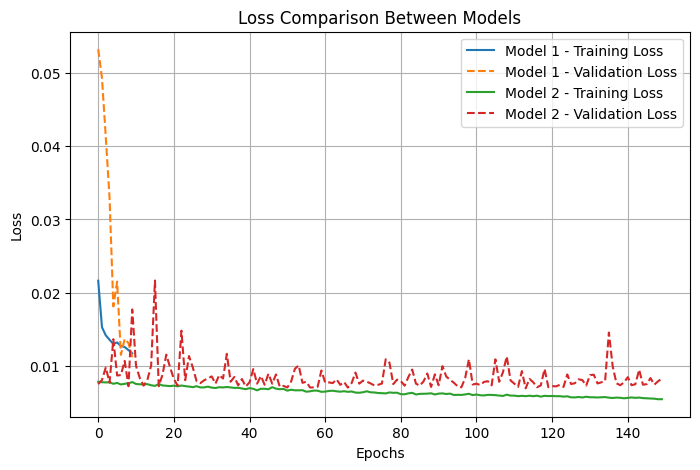

In [ ]:
import matplotlib.pyplot as plt

# Plot loss for both models
plt.figure(figsize=(8, 5))
plt.plot(history1.history['loss'], label="Model 1 - Training Loss", linestyle="-")
plt.plot(history1.history['val_loss'], label="Model 1 - Validation Loss", linestyle="--")
plt.plot(history2.history['loss'], label="Model 2 - Training Loss", linestyle="-")
plt.plot(history2.history['val_loss'], label="Model 2 - Validation Loss", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison Between Models")
plt.legend()
plt.grid()
plt.show()

Showing an example of grayscale image turn into colorful image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


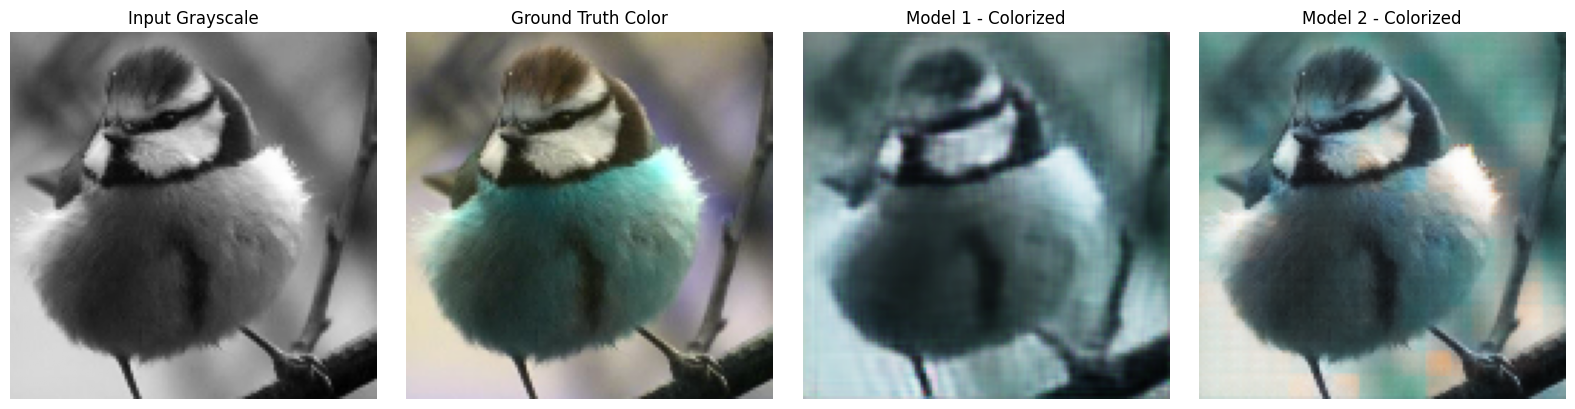

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Select a test grayscale image and its ground truth color image
test_img = X_test[5:6]  # Grayscale input
original_color = (Y_test[5] * 255).astype(np.uint8)  # Ground truth color image (rescaled to 0-255)
# Generate colorized images from both models
predicted_color1 = model1.predict(test_img)[0]  # Model 1 output
predicted_color2 = model2.predict(test_img)[0]  # Model 2 output

# Convert predicted images to 0-255 range for visualization
predicted_color1 = (predicted_color1 * 255).astype(np.uint8)
predicted_color2 = (predicted_color2 * 255).astype(np.uint8)

# Display results including original ground truth
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].imshow(test_img[0].squeeze(), cmap='gray')
ax[0].set_title("Input Grayscale")

ax[1].imshow(original_color)
ax[1].set_title("Ground Truth Color")

ax[2].imshow(predicted_color1)
ax[2].set_title("Model 1 - Colorized")

ax[3].imshow(predicted_color2)
ax[3].set_title("Model 2 - Colorized")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()
